In [1]:
import re
import numpy as np
import pandas as pd
from scipy import linalg as LA
from matplotlib import pyplot as plt

WORD_FREQ_THRESHOLD = 5 # Min numbers of appearences to show in bag of words

# Load data
df = pd.read_csv('winemag-data-130k-v2.csv', index_col=0)
# We used the columns taster_name, points, and description, therefore we clean out the nans
df.dropna(subset=['taster_name','points','description'], inplace=True)
df_use = df.loc[df['taster_name'] == 'Alexander Peartree']
X_raw = df_use["description"].values
Y_raw = df_use["points"].values

# Data Preprocessing

In [2]:
# Preprocess Y (easy)
Y = Y_raw.reshape(-1, 1)

# Preprocess X into Bag of Words representation
regex = re.compile('[^a-zA-Z \-]') # Normalize to just a-z
X_pp = [regex.sub('', x_i).lower() for x_i in X_raw] # X as list of sentences
X_ary = [x_i.split(' ') for x_i in X_pp] # X as list of list of words
X_corpus = ' '.join(X_pp) # X as one long string


illegal_words = [''] # Words to remove from vocab
words = list(filter(lambda w: w not in illegal_words, X_corpus.split(" "))) # vocab

# Get word frequencies
freqs = {}
for token in words:
    if token not in freqs:
        freqs[token] = 0
    freqs[token] += 1

# Get sorted list of vocab in reverse order
freqs_sorted = list(reversed(sorted([(k, v) for k, v in freqs.items()], key=lambda x: x[1])))

# Remove rare words from vocab
top_freqs = list(filter(lambda x: x[1] > WORD_FREQ_THRESHOLD, freqs_sorted))

# Assign index to each word in vocab
word_to_idx = dict(zip(map(lambda x: x[0], top_freqs), range(len(top_freqs))))

# Build matrix of rows: sentence in Y, cols: word in vocab
X = np.zeros((len(X_ary), len(top_freqs)))
for s_i in range(len(X_ary)):
    for w in X_ary[s_i]:
        if w in word_to_idx:
            X[s_i, word_to_idx[w]] += 1

In [3]:
X.shape, Y.shape

((415, 421), (415, 1))

# Kernel Functions

In [4]:
class TFIDF():
    def __init__(self, X):
        self.shape = X.shape
        self.N, self.V = self.shape
        self.X = X
        self.tf_idf = self._tf_idf()
        
        print(self.N, "Documents.", self.V, "Words (with rare words removed).")
    
    def _tf(self, x_ij):
        """Return the term frequency for a word in a document"""
        return np.log(1 + x_ij)
    
    def _idf(self, j):
        """Return the inverse document frequency for a given word"""
        return np.log(self.N / (1 + np.sum(self.X[:, j] > 0)))
    
    def _tf_idf_row(self, x_i):
        """Return the TF-IDF for a given document"""
        ret = np.zeros([self.V])
        for j in range(self.V):
            ret[j] = self._tf(x_i[j]) * self._idf(j)
        return ret
    
    def _tf_idf(self):
        """Return the TF-IDF for every document in X"""
        ret = np.zeros([self.N, self.V])
        for i in range(self.N):
            ret[i, :] = self._tf_idf_row(self.X[i])
        return ret
    
    def __getitem__(self, i):
        return self.tf_idf[i]
    
    def kernel(self, phi_x_i1, phi_x_i2):
        ret = (phi_x_i1.T @ phi_x_i2)
        return ret / (LA.norm(phi_x_i1) * LA.norm(phi_x_i2))
    
    def gram(self):
        K = np.zeros([self.N, self.N])
        for i1 in range(self.N):
            for i2 in range(self.N):
                K[i1, i2] = self.kernel(self[i1], self[i2])
        return K

In [5]:
def get_linear_gram(Y):
    N = Y.shape[0]
    L = np.zeros([N, N])
    for i1 in range(N):
        for i2 in range(N):
            L[i1, i2] = Y[i1].dot(Y[i2])
    return L

# Kernel CCA

In [6]:
def kernel_cca(X, Y, reg=1e-5):
    K = TFIDF(X).gram()
    L = get_linear_gram(Y)
    
    
    N = K.shape[0]
    H = np.eye(N) - (1 / N * np.ones(N))
    Z = np.zeros([N, N])
    
    Kt = H @ K @ H
    Lt = H @ L @ H
    
    A1 = np.r_['1', Z, K @ L]
    A2 = np.r_['1', L @ K, Z]
    A = np.r_[A1, A2]
    
    B1 = np.r_['1', (K@K + (reg*np.eye(N)) * K), Z]
    B2 = np.r_['1', Z, (L@L + (reg*np.eye(N)) * L)]
    B = np.r_[B1, B2]
    
    eig_vals, eig_vecs = LA.eig(A, B)
    eig_vals = np.real(eig_vals)
    eig_vecs = np.real(eig_vecs)
    
    max_idx = np.argmax(eig_vals)
    max_vec = eig_vecs[:, max_idx].reshape(2*N, 1)
    
    max_vec = max_vec / LA.norm(max_vec)
    
    alpha = max_vec[:N]
    beta = max_vec[N:]
    
    return alpha, beta, K, L

## Results

The cell below gives what we feel is the optimal result given the data.

415 Documents. 421 Words (with rare words removed).
Correlation Coeff: 0.9657311846882887


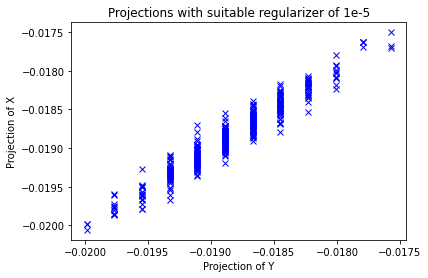

In [7]:
alpha, beta, K, L = kernel_cca(X, Y, reg=1e-5)

X_proj = alpha.T @ K
Y_proj = beta.T @ L

print("Correlation Coeff:", np.corrcoef(X_proj, Y_proj)[0, 1])
plt.plot(Y_proj, X_proj, 'bx')
plt.title("Projections with suitable regularizer of 1e-5")
plt.ylabel("Projection of X")
plt.xlabel("Projection of Y")
plt.show()

Although we found higher correlation coefficients when using smaller regularization terms, we feel as though this is not a good representation of the data due to its sparse nature.

Below you can see that the we are reaching a high correlation near 1 which indicates that we have a projection with no components orthagonal to the feature space.

415 Documents. 421 Words (with rare words removed).
Correlation Coeff: 0.9999821524663274


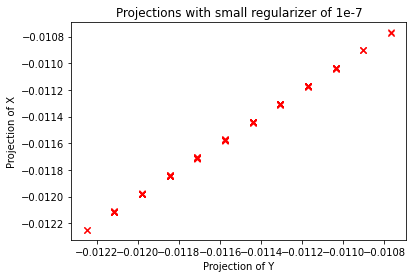

In [8]:
alpha, beta, K, L = kernel_cca(X, Y, reg=1e-7)

X_proj = alpha.T @ K
Y_proj = beta.T @ L

print("Correlation Coeff:", np.corrcoef(X_proj, Y_proj)[0, 1])
plt.plot(Y_proj, X_proj, 'rx')
plt.title("Projections with small regularizer of 1e-7")
plt.ylabel("Projection of X")
plt.xlabel("Projection of Y")
plt.show()